In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
from tqdm import tqdm
import tensorflow as tf


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import SimpleRNN

okt = Okt()

In [7]:
# vocab_size = 20000  # 빈도수 상위 2만개의 단어만 사용
# max_len = 200  # 문장의 최대 길이

In [8]:
train_data = pd.read_csv('X_train.csv')
test_data = pd.read_csv('X_test.csv')

In [9]:
print(train_data)

         num  label                                           document
0          1      4                          일은 왜 해도 해도 끝이 없을까? 화가 난다.
1          2      4     이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.
2          3      4  회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...
3          4      4  직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...
4          5      4              얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.
...      ...    ...                                                ...
51625  51626      4     나이가 먹고 이제 돈도 못 벌어 오니까 어떻게 살아가야 할지 막막해. 능력도 없고.
51626  51627      1        몸이 많이 약해졌나 봐. 이제 전과 같이 일하지 못할 것 같아 너무 짜증 나.
51627  51628      5   이제 어떻게 해야 할지 모르겠어. 남편도 그렇고 노후 준비도 안 되어서 미래가 걱정돼.
51628  51629      1  몇십 년을 함께 살았던 남편과 이혼했어. 그동안의 세월에 배신감을 느끼고 너무 화가 나.
51629  51630      5  남편과 결혼한 지 사십 년이야. 이제 사람 만나는 것도 버겁고 알던 사람도 점점 사라져.

[51630 rows x 3 columns]


In [10]:
# train_data['document'].nunique(), train_data['label'].nunique() # document 열의 중복 제거
# train_data.drop_duplicates(subset=['document'], inplace=True)
# print('총 샘플의 수 :',len(train_data))
# print(train_data.groupby('label').size().reset_index(name = 'count'))
# train_data['label'].value_counts().plot(kind = 'bar')

# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 6641


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22040\729634971.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22040\729634971.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


In [11]:
okt = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)


# threshold = 3
# total_cnt = len(tokenizer.word_index) # 단어의 수
# rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
# total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
# rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
# for key, value in tokenizer.word_counts.items():
#     total_freq = total_freq + value

#     # 단어의 등장 빈도수가 threshold보다 작으면
#     if(value < threshold):
#         rare_cnt = rare_cnt + 1
#         rare_freq = rare_freq + value

# print('단어 집합(vocabulary)의 크기 :',total_cnt)
# print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
# print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
# print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
# # 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# # 0번 패딩 토큰을 고려하여 + 1
# vocab_size = total_cnt - rare_cnt + 1
# print('단어 집합의 크기 :',vocab_size)



vocab_size = 20000  # 빈도수 상위 2만개의 단어만 사용
max_len = 50  # 문장의 최대 길이

tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(X_train[:3])
print(X_test[:3])

print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

100%|██████████| 6641/6641 [00:17<00:00, 378.67it/s]


[[29, 94, 306, 306, 870, 9, 74, 56], [55, 311, 188, 1480, 1916, 3082, 468, 421, 21, 90, 1916, 4, 74, 3], [28, 822, 325, 3083, 2810, 101, 125, 185, 12, 44, 119, 19]]
[[55, 385, 10, 559, 2, 287, 402, 46, 253, 9684, 1, 19, 4, 159], [28, 10, 635, 385, 100, 20, 1069, 191, 249], [162, 4, 249, 116, 854, 26, 4, 191]]
훈련용 리뷰 개수 : 51630
테스트용 리뷰 개수 : 6641


발화의 최대 길이 : 50
발화의 평균 길이 : 50.0


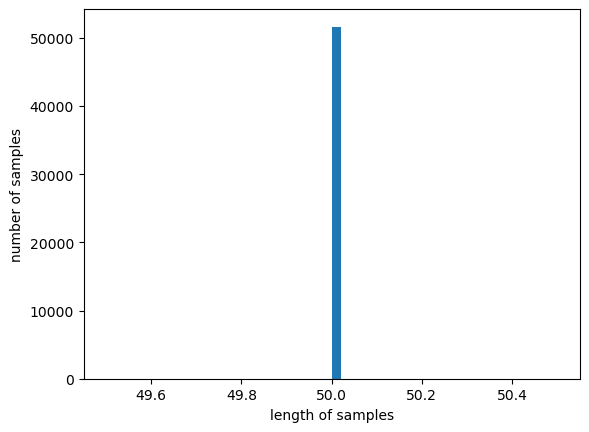

In [12]:
import numpy as np
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

print('발화의 최대 길이 :',max(len(review) for review in X_train))
print('발화의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [13]:
print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))

훈련용 리뷰 개수 : 51630
테스트용 리뷰 개수 : 6641


In [14]:
# print("\n 테스트 정확도: %.4f" % (model.evaluate("철수랑 싸웠어", 4)))
embedding_dim = 256 # 임베딩 벡터의 차원
hidden_units = 128  # 뉴런의 수

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(6, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, 
                                           save_best_only=True)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', 
                           metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], 
                               batch_size=64, validation_split=0.2)

print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))
print(((X_test, y_test)))

Epoch 1/15
646/646 [==============================] - ETA: 0s - loss: 1.3205 - acc: 0.5027
Epoch 1: val_acc improved from -inf to 0.38117, saving model to best_model.h5
646/646 [==============================] - 132s 197ms/step - loss: 1.3205 - acc: 0.5027 - val_loss: 1.6089 - val_acc: 0.3812
Epoch 2/15
646/646 [==============================] - ETA: 0s - loss: 1.1146 - acc: 0.5902
Epoch 2: val_acc improved from 0.38117 to 0.38621, saving model to best_model.h5
646/646 [==============================] - 109s 169ms/step - loss: 1.1146 - acc: 0.5902 - val_loss: 1.6347 - val_acc: 0.3862
Epoch 3/15
646/646 [==============================] - ETA: 0s - loss: 1.0567 - acc: 0.6150
Epoch 3: val_acc did not improve from 0.38621
646/646 [==============================] - 121s 187ms/step - loss: 1.0567 - acc: 0.6150 - val_loss: 1.6252 - val_acc: 0.3834
Epoch 4/15
646/646 [==============================] - ETA: 0s - loss: 1.0122 - acc: 0.6352
Epoch 4: val_acc did not improve from 0.38621
646/646 [=

In [15]:
# sentiment_predict('철수랑 싸웠어')

In [16]:
# loaded_model = load_model('transformer_model.h5')
def predict(sentence) :
    sentence = okt.morphs(sentence, stem=True) # 토큰화
    x_test = tokenizer.texts_to_sequences([sentence])

    x_test = pad_sequences(x_test, maxlen=50)
    print(x_test)
    print(model.predict(x_test))

sentence = "기쁨"
predict(sentence)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0 4825]]
1/1 [==============================] - 1s 887ms/step
[[0.284112   0.1284523  0.13363278 0.13357721 0.1581092  0.16211656]]


In [17]:
# import os
# print('JAVA_HOME' in os.environ)

In [18]:
# os.environ['JAVA_HOME'] = r'C:\Program Files\Java\jdk-17.0.2\bin\server'